# General Settings

Import Libraries that are used in the Reinforcement Learning algorithm

In [68]:
import torch 
import torch.nn as nn
import numpy as np
from torch.autograd import Variable
import os
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import copy
from itertools import count
from hopperenv import *     # Our Rocket Hopper Environment
import matplotlib.pyplot as plt
import random
import copy
import gym

In [69]:
print(f"PyTorch version: {torch.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Gym version: {gym.__version__}")

PyTorch version: 2.1.1+cpu
NumPy version: 1.26.2
Gym version: 0.26.2


In [70]:
# helper function for plotting
def plot(states):
    num_states = states.shape[0]
    time = np.arange(states.shape[1])

    plt.figure(figsize=(10, 2*num_states))

    names = ["position [m]","velocity [m/s]","acceleration [m/s²]","p_set [bar]","p_actual [bar]","x_target [m]","error [m]","reward","?"]
    colors = ["tab:blue","tab:orange","tab:purple","tab:green","tab:green","tab:grey","tab:red","tab:cyan","black"]

    for i in range(num_states):
        plt.subplot(num_states, 1, i + 1)
        plt.plot(time, states[i, :], label=names[i],color=colors[i])
        if i == 6: # error
            plt.fill_between(time, 0, states[i, :], color=colors[i], alpha=0.5)
        plt.ylabel(names[i])
        plt.legend()
        plt.grid(True)

    plt.xlabel('Time [steps]')
    plt.tight_layout()
    plt.show()

### Hyperparameter Settings

The configuration initially follows the [supplementary information section](https://arxiv.org/pdf/1509.02971.pdf?ref=blog.paperspace.com) of the DDPG paper in page 11.

Hyperparameters not only affect the reinforcement learning algorithm but also th the exploration strategy and the environment. DDPG generally provides good results in continuous control problems (Duan et al., 2016) but is more sensitive to numerous hyperparameters than other algorithms (Rupam Mahmood et al., 2018).

These are grouped into DDPG, Exploration, and Environmental Hyperparameters as outlined below:

#### DDPG Hyperparameters

- **Batch Size**: Number of samples used during an update (gradient descent)
- **Gamma**: Discount factor ∈ [0, 1] defines up to what extent future rewards influence the return in time step t.
- **Actor and Critic Learning Rates**: Defines the step size in solution direction and controls how strongly the weights of the artificial neural network are updated by the loss gradient.
- **Number of Neurons**: Layer Size of the neural network.
- **Regularization Factor Critic**: Method to prevent overfitting and improve models generalization properties.
- **Memory Capacity**: Size of the memory containing the batch samples.


#### Exploration Hyperparameters

Sometimes exploration is not necessary - it depends on the environment. If uncertain, an exploration strategy is applied - an Ornstein-Uhlenbeck Process (OUP) is selected in this case.

The hyperparameters of the OUP are:

- **Mean**: Mean value of the OUP
- **Theta**: Reversion rate of the OUP
- **Sigma**: Standard deviation of the OUP

#### Environmental Hyperparameters

The environment has context-specific hyperparameters. Depending on the environment, arbitrary ones can be included. For example. the training duration can be one. A longer training duration allows the agent to interact with his environment for a longer  period of time at the expense of computational cost.


### Hyperparameter Optimization Methods

The suitable hyperparameters are problem-specific and the optimal hyperparameter combination is often not intuitive. The widespread manual choice of hyperparameters therefore requires experties and is time-consuming (Liessner et.al., 2019).

Several strategies are presented that can be followed depending on the approach. There are **Model-free Approaches** and **Model-based Approaches**.

- **Model-free Approaches**:
    - Grid Search - discrete, grid-shaped substed instead of the entire parameter space.
    - Random Search - selects hyperparameters from the equally distributed search space.
    - These algorithms can use the knowledge gained during their processing to adapt and intensify the search in areasof the search space with high *result potential*.

Bergstra and Bengio proved that the random choice of hyperparameter combinations is more efficient than searching a grid subset (Bergstra and Bengio, 2012). These approaches prevent the convergence into local optima but are extremely time-consuming  due to the *curse of dimensionality* in large  parameter spaces.


In [71]:
BUFFER_SIZE=1000000 # Buffer size of 1 million entries

BATCH_SIZE=128   # Sampling from memory - This can be 128 for more complex tasks such as Hopper
UPDATE_ITERATION=100 # Number of iterations in the replay buffer

tau=0.01       # Target Network HyperParameters (soft updating)
gamma=0.99      # ?

directory = './'

# Neural Network architecture:
H1=64  # Neuron of 1st Layers #400 #20 # 64
H2=128  # Neurons of 2nd layers #300 #64 # 128

# TODO: Iterate over H1 & H2, Play with Learning rates for actor and critic

### Exploration 


#### Exploration vs Exploitation

A major challenge in reinforcement learning is the balance between exploration and exploitation. In order to achieve high rewards, the agent has to choose actions that have proven to be particularlu rewarding in the past. In order to discover such actions in the first place, new actions have to be tested. This means the agent has to *exploit* knowledge already learned from the environment to get a reward, and at the same time explore other actions to have a better strategy in the future (Sutton and Barto, 1998). 

Various exploration strategies are available for this purpose. In (Plappert et al., 2017), M. Plappert compares several exploration strategies for continuous action spaces.  Additionally Lilicrap compares the uncorrelated action noise to the additive Gaussian action noise (based on the OUP). The latter changes less abruptly from one timestep to the next (Lilicrap et al., 2015). This characteristic can be beneficial for the control of physical actuators.


To ensure **exploration**, we have to add noise to the action. An **Ornstein-Uhlenbeck** process is chosen to add noise in a smooth way, suitable for continuous control tasks.

In [72]:
class OU_Noise(object):
    """Ornstein-Uhlenbeck process.
    
    The OU_Noise class has four attributes
    
        size: the size of the noise vector to be generated
        mu: the mean of the noise, set to 0 by default
        theta: the rate of mean reversion, controlling how quickly the noise returns to the mean
        sigma: the volatility of the noise, controlling the magnitude of fluctuations
    """

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.25):
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample.
        This method uses the current state of the noise and generates the next sample
        """
        dx = self.theta * (self.mu - self.state) + self.sigma * np.array([np.random.normal() for _ in range(len(self.state))])
        self.state += dx
        return self.state

### Replay Buffer
Implement a simple replay buffer without priority

In [73]:
class Replay_buffer():
    '''
    Code based on:
    https://github.com/openai/baselines/blob/master/baselines/deepq/replay_buffer.py
    Expects tuples of (state, next_state, action, reward, done)
    '''
    def __init__(self, max_size=BUFFER_SIZE):
        """Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self.storage = []
        self.max_size = max_size
        self.ptr = 0

    def push(self, data):
        if len(self.storage) == self.max_size:
            self.storage[int(self.ptr)] = data
            self.ptr = (self.ptr + 1) % self.max_size
        else:
            self.storage.append(data)

    def sample(self, BATCH_SIZE):
        """Sample a batch of experiences.
        Parameters
        ----------
        BATCH_SIZE: int
            How many transitions to sample.
        Returns
        -------
        state: np.array
            batch of state or observations
        action: np.array
            batch of actions executed given a state
        reward: np.array
            rewards received as results of executing action
        next_state: np.array
            next state next state or observations seen after executing action
        done: np.array
            done[i] = 1 if executing ation[i] resulted in
            the end of an episode and 0 otherwise.
        """
        ind = np.random.randint(0, len(self.storage), size=BATCH_SIZE)
        state, next_state, action, reward, done = [], [], [], [], []

        for i in ind:
            st, n_st, act, rew, dn = self.storage[i]
            state.append(np.array(st, copy=False))
            next_state.append(np.array(n_st, copy=False))
            action.append(np.array(act, copy=False))
            reward.append(np.array(rew, copy=False))
            done.append(np.array(dn, copy=False))

        return np.array(state), np.array(next_state), np.array(action), np.array(reward).reshape(-1, 1), np.array(done).reshape(-1, 1)


### Network Architecture

Network architecture is defined:

- **Actor** is composed of:
    - 3 FC (Fully-connected) Layers 
    - Hyperbolic tangent as the activation function -> Deals with a *-1,1* value range

- **Critic** is composed of:
    - Input: *state* & *action*
    - Output: Q-value after 3 FC Layers


In complex tasks, a *higher batch size* is required (128 instead of 64) and *batch normalisation layers* between input and hidden layers in both actor and critic.

In [74]:
class Actor(nn.Module):
    """
    The Actor model takes in a state observation as input and 
    outputs an action, which is a continuous value.
    
    It consists of four fully coonected linear layers with ReLU activation functions and 
    a final output layer selects one single optimized action for the state
    """
    def __init__(self, n_states, action_dim, H1):
        super(Actor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(n_states, H1), 
            nn.ReLU(), 
            # nn.Linear(H1, H1), 
            # nn.ReLU(), 
            # nn.Linear(H1, H1), 
            # nn.ReLU(), 
            nn.Linear(H1, action_dim)
        )
        
    def forward(self, state):
        return self.net(state)

class Critic(nn.Module):
    """
    The Critic model takes in both a state observation and an action as input and 
    outputs a Q-value, which estimates the expected total reward for the current state-action pair. 
    
    It consists of four linear layers with ReLU activation functions, 
    State and action inputs are concatenated before being fed into the first linear layer. 
    
    The output layer has a single output, representing the Q-value
    """
    def __init__(self, n_states, action_dim, H2):
        super(Critic, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(n_states + action_dim, H2), 
            nn.ReLU(), 
            # nn.Linear(H2, H2), 
            # nn.ReLU(), 
            # nn.Linear(H2, H2), 
            # nn.ReLU(), 
            nn.Linear(H2, action_dim)
        )
        
    def forward(self, state, action):
        return self.net(torch.cat((state, action), 1))

### GPU Setup 

GPU is used for faster training if your machine has one 

In [75]:
#set GPU for faster training
cuda = torch.cuda.is_available() #check for CUDA
device   = torch.device("cuda" if cuda else "cpu")
print("Job will run on {}".format(device))

Job will run on cpu


### DDPG Agent

Creates a replay buffer, an actor-critic network and their corresponding target networks. Additionally, it also initializes the optimizer for both networks.

In [76]:
class DDPG(object):
    def __init__(self, state_dim, action_dim):
        """
        Initializes the DDPG agent. 
        Takes three arguments:
               state_dim which is the dimensionality of the state space, 
               action_dim which is the dimensionality of the action space, and 
               max_action which is the maximum value an action can take. 
        
        Creates a replay buffer, an actor-critic  networks and their corresponding target networks. 
        It also initializes the optimizer for both actor and critic networks alog with 
        counters to track the number of training iterations.
        """
        self.replay_buffer = Replay_buffer()
        
        self.actor = Actor(state_dim, action_dim, H1).to(device)
        self.actor_target = Actor(state_dim, action_dim,  H1).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=10e-3)

        self.critic = Critic(state_dim, action_dim,  H2).to(device)
        self.critic_target = Critic(state_dim, action_dim,  H2).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=2e-2)
        # learning rate

        

        self.num_critic_update_iteration = 0
        self.num_actor_update_iteration = 0
        self.num_training = 0


    def select_action(self, state):
        """
        takes the current state as input and returns an action to take in that state. 
        It uses the actor network to map the state to an action.
        """
        #print(f"Doing an Action: state {state} reshaped {state.reshape(1, -1)}")
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        # print(state) # tensor([[0., 0.]])
        return self.actor(state).cpu().data.numpy().flatten()

    def update(self):
        """
        updates the actor and critic networks using a batch of samples from the replay buffer. 
        For each sample in the batch, it computes the target Q value using the target critic network and the target actor network. 
        It then computes the current Q value using the critic network and the action taken by the actor network. 
        
        It computes the critic loss as the mean squared error between the target Q value and the current Q value, and 
        updates the critic network using gradient descent. 
        
        It then computes the actor loss as the negative mean Q value using the critic network and the actor network, and 
        updates the actor network using gradient ascent. 
        
        Finally, it updates the target networks using soft updates, where a small fraction of the actor and critic network weights 
        are transferred to their target counterparts. 
        This process is repeated for a fixed number of iterations.
        """

        for it in range(UPDATE_ITERATION):
            # For each Sample in replay buffer batch
            state, next_state, action, reward, done = self.replay_buffer.sample(BATCH_SIZE)
            state = torch.FloatTensor(state).to(device)
            #print(state)
            action = torch.FloatTensor(action).to(device)
            next_state = torch.FloatTensor(next_state).to(device)
            done = torch.FloatTensor(1-done).to(device)
            reward = torch.FloatTensor(reward).to(device)

            # Compute the target Q value
            target_Q = self.critic_target(next_state, self.actor_target(next_state))
            target_Q = reward + (done * gamma * target_Q).detach()

            # Get current Q estimate
            current_Q = self.critic(state, action)

            # Compute critic loss
            critic_loss = F.mse_loss(current_Q, target_Q)
            
            # Optimize the critic
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()

            # Compute actor loss as the negative mean Q value using the critic network and the actor network
            actor_loss = -self.critic(state, self.actor(state)).mean()
            

            # Optimize the actor
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            
            """
            Update the frozen target models using 
            soft updates, where 
            tau,a small fraction of the actor and critic network weights are transferred to their target counterparts. 
            """
            for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

            for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
            
           
            self.num_actor_update_iteration += 1
            self.num_critic_update_iteration += 1
    def save(self):
        """
        Saves the state dictionaries of the actor and critic networks to files
        """
        torch.save(self.actor.state_dict(), directory + 'actor.pth')
        torch.save(self.critic.state_dict(), directory + 'critic.pth')
        

    def load(self):
        """
        Loads the state dictionaries of the actor and critic networks to files
        """
        self.actor.load_state_dict(torch.load(directory + 'actor.pth'))
        self.critic.load_state_dict(torch.load(directory + 'critic.pth'))
       


### Initialize a DDPG Instance

Call the environment to be trained. Always use the same seed for data reproducibility

In [77]:
# Example environment:
# create the environment
# env_name='MountainCarContinuous-v0'
# env = gym.make(env_name)

# new environment
env = HopperEnv()


# XX
# device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define different parameters for training the agent:
    # Episodes:
MAX_EPISODE=20          # Number of episodes 200
ep_r = 0          # Initial episode reward: normally 0 or -infinity
score_hist=[]           # Initialize the list where all historical rewards of each episode are stored
    # Steps:
MAX_TIME_STEPS=960       # Number of steps taken per episode before moving on # 5000
total_step = 0          # Initialize step count in each episode: [0, MAX_TIME_STEPS]

# # To render the environmnet:
# render=True
# render_interval=10

# For Reproducibility:
# env.seed(0)
torch.manual_seed(0)
np.random.seed(0)

# Environment action and states
state_dim = env.observation_space.shape[0]
print(state_dim)
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])
min_action = float(env.action_space.low[0])
min_Val = torch.tensor(1e-7).float().to(device) 


# Exploration Noise
exploration_noise=0.05 # [bar]

3


c:\Users\Usuario\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


### Iterate Through Episodes

In [78]:
def map(value, from_min, from_max, to_min, to_max):
    return np.clip((value - from_min) / (from_max - from_min) * (to_max - to_min) + to_min, to_min, to_max)

In [89]:
# Create a DDPG instance
agent = DDPG(state_dim, action_dim)
print("State dim: {}, Action dim: {}".format(state_dim, action_dim))

episodes = []
actions = []

# Train the agent for the number of episodes set:
for i in range(MAX_EPISODE):
    total_reward = 0
    step = 0
    state = env.reset() # [x_target, x, a]
    log = np.zeros((8,MAX_TIME_STEPS))
    
    # state=state[0]

    for  t in range(MAX_TIME_STEPS):
        action = agent.select_action(state) # range ? [-1..1] (?)
        action = map(action, -1, 1, min_action, max_action) # [0..7]
        if t==0: actions.append(action[0])
            
        #print(action)
        # Add Gaussian noise to actions for exploration
        action = (action + np.random.normal(0, exploration_noise, size=action_dim)).clip(min_action, max_action)
        # print(env.step(action))
        #action += OU_Noise.sample(action)
        #action = np.array([7]) # test full throttle

        y, reward, done, info = env.step(action)
        # print(env.step(action))
        #y = np.array([state[1],state[2]])
        # print(len(info))
        log[0,t] = y[1] # x
        # log[1,t] = info[1] # v
        log[2,t] = y[2] # a
        log[3,t] = action[0] # p_set
        # log[4,t] = info[0] # p_actual
        log[5,t] = y[0] # x_target
        log[6,t] = y[1] - y[0] # error
        log[7,t] = reward # reward
        

        total_reward += reward
        # if render and i >= render_interval : env.render()
        agent.replay_buffer.push((state, y, action, reward, float(done)))

        state = y
        # print(state)
        if done:
            break
        step += 1
        
    score_hist.append(total_reward)
    episodes.append(log)
    
    total_step += step+1
    print(f"Episode: {i}  Total Reward: {total_reward:10.2f}", end='\r', flush=True)
    
    agent.update()
    if i % 100 == 0:
        agent.save()
env.close()

State dim: 3, Action dim: 1


Printing random: Episode 17 


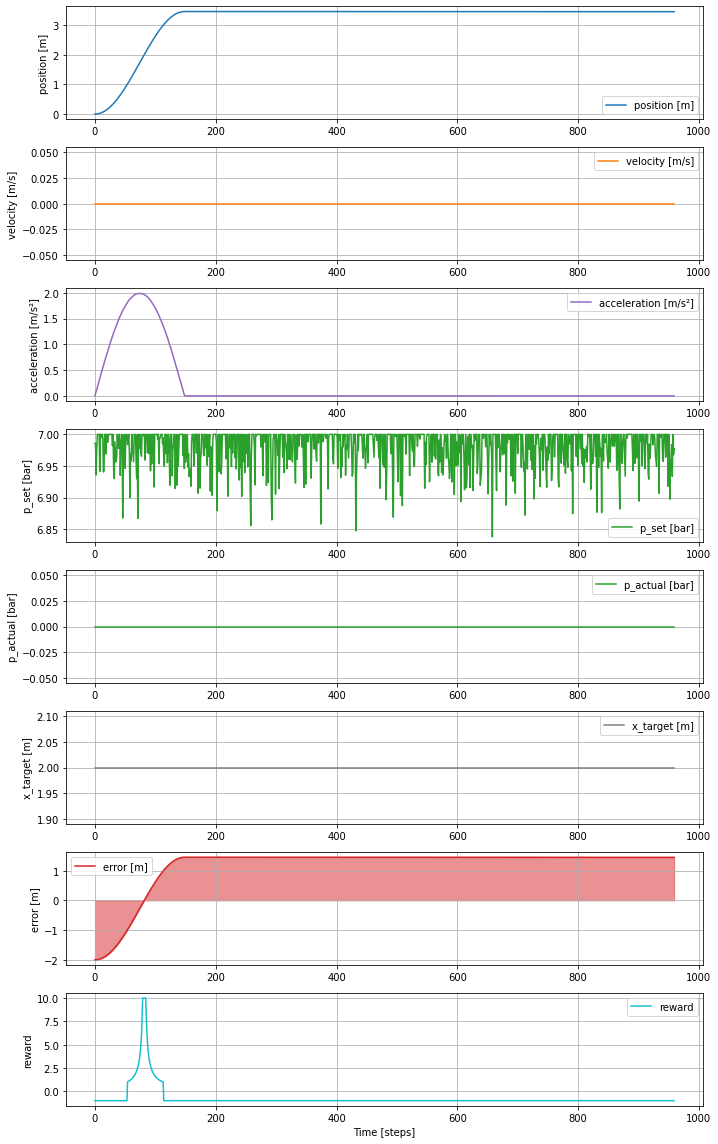

In [107]:
# Plot a random episode 
random_episode = int(random.uniform(1,len(episodes)))
print(f"Printing random: Episode {random_episode} ")
plot(episodes[random_episode])

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np
def plot_learning_curve(x, scores):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    #plt.savefig(figure_file)
    plt.show()

#### Plot Reward History Average

Over all the episodes, the reward history average is plotted per episode

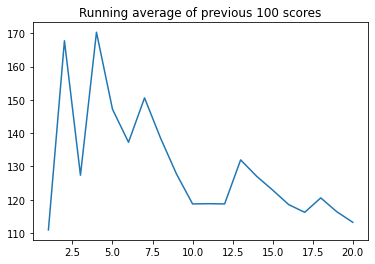

In [ ]:
x = [i+1 for i in range(len(score_hist))]
plot_learning_curve(x, score_hist)

In [ ]:
test_iteration=10              # 100
max_length_of_trajectory=100   # 1000 
for i in range(test_iteration):
    state = env.reset()
    for t in count():
        action = agent.select_action(state)
        action = map(action, -1, 1, min_action, max_action)
        next_state, reward, done, info = env.step(np.float32(action))
        ep_r += reward
        #print(reward)
        
        # env.render()
        if done: 
            # print("reward{}".format(reward))
            print("Episode \t{}, the episode reward is \t{:0.2f}".format(i, ep_r))
            ep_r = 0
            # env.render()
            break
        state = next_state
env.close()   

Episode 	0, the episode reward is 	-960.00
Episode 	1, the episode reward is 	-960.00
Episode 	2, the episode reward is 	-960.00
Episode 	3, the episode reward is 	-960.00
Episode 	4, the episode reward is 	-960.00
Episode 	5, the episode reward is 	-960.00
Episode 	6, the episode reward is 	-960.00
Episode 	7, the episode reward is 	-960.00
Episode 	8, the episode reward is 	-960.00
Episode 	9, the episode reward is 	-960.00
